In [93]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="llama3")

from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llama3")

In [94]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [95]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [96]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [97]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [98]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['ec63d96a-c62c-45a6-b70a-efab22b5d60f', '3710d2e1-4f7c-48a8-a7e9-7ae90b3fc8de', '876c20be-50f4-4844-bfce-e286076e5b57']


In [99]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

C:\Users\lonyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [100]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [101]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}

In [102]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

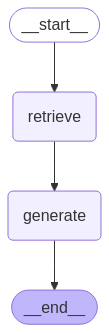

In [103]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [104]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='af6e978f-c832-4b19-9234-8f12608ebd18', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5929}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(id='fd3d7e1f-3e88-49ab-bb74-9e6102f7d752', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 21623}, page_content='This benchmark evaluates the agent’s tool use capabilities at three levels:\n\nLevel-1 evaluates the ability to call the API. Given an API’s description, the model needs to determine whether to call a given API, call it correctly, and respond properly to API returns.\nLevel-2 examines the ability to retrieve the API. The model needs to search for possible APIs that may solve the user’s requirement and learn how to use them by reading documentation.\nLevel-3 assesses the ability to plan AP

In [105]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='af6e978f-c832-4b19-9234-8f12608ebd18', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5929}, page_content='Fig. 4. Experiments on AlfWorld Env and HotpotQA. Hallucination is a more common failure than inefficient planning in AlfWorld. (Image source: Shinn & Labash, 2023)'), Document(id='fd3d7e1f-3e88-49ab-bb74-9e6102f7d752', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 21623}, page_content='This benchmark evaluates the agent’s tool use capabilities at three levels:\n\nLevel-1 evaluates the ability to call the API. Given an API’s description, the model needs to determine whether to call a given API, call it correctly, and respond properly to API returns.\nLevel-2 examines the ability to retrieve the API. The model needs to search for possible APIs that may solve the user’s requirement and learn how to use them by reading documentation.\nLevel-3 assesses the ab

In [106]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")